#### Graph minibatch learning tutorial 1
References
- https://docs.dgl.ai/en/0.8.x/guide/minibatch-node.html#guide-minibatch-node-classification-sampler


In [10]:
import numpy as np

from tqdm import tqdm

import dgl
import dgl.nn as dglnn
import torch
import torch.nn as nn
import torch.nn.functional as F

# GPUが利用可能かどうかを確認
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA available: True
Device name: NVIDIA GeForce RTX 4090


***
##### データの準備

In [2]:

# load graph information
dataset = dgl.data.CiteseerGraphDataset()
g = dataset[0]

num_nodes = g.num_nodes()

# split train, validation, test
train_ratio = 0.8
val_ratio = 0.1

nids = np.arange(num_nodes)
np.random.shuffle(nids)

train_size = int(num_nodes * train_ratio)
val_size = int(num_nodes * val_ratio)

train_nids = torch.tensor(nids[:train_size])
val_nids = torch.tensor(nids[train_size:train_size+val_size])
test_nids = torch.tensor(nids[train_size+val_size:])

# data loader
sampler = dgl.dataloading.MultiLayerFullNeighborSampler(2)
dataloader = dgl.dataloading.DataLoader(
    g, train_nids, sampler,
    batch_size=128,
    shuffle=True,
    drop_last=False,
    num_workers=0)  # num_workers=1 couldnt work   
input_nodes, output_nodes, blocks = next(iter(dataloader))

  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


/root/.pyenv/versions/3.10.9/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(


In [3]:
print(input_nodes)
print(output_nodes)
print(blocks)

tensor([2703, 3302, 2172,  ..., 2553, 1846, 1491])
tensor([2703, 3302, 2172, 2769, 1190,  595, 2879, 1878, 1944, 1710,  535, 1054,
         489, 1873,  829, 1115, 2950, 2695, 3147, 3171,  798,  750, 3245, 1754,
        1318, 1079, 1670, 1001, 2199, 2825, 2449,    9, 1788, 2317,  567, 2609,
          44, 3294,  314,  850,  927,  471, 1114, 3255, 3241, 1886, 1586,  968,
        2577, 2248, 2139,   73, 3041, 2909, 1622, 2901,  323, 1736, 3163,  980,
        1509,  317, 1387,  933, 1932, 1219, 1798, 2576, 1412, 3275, 2137,  251,
        2090, 2727, 3289,  788, 2112,   53, 3084,   24, 2962, 2124,  886, 3020,
        1040,   97, 3178, 1590, 2927, 2003, 3301, 2619,  565, 2511,  477,  139,
        2113,  356,  201,   86,  598,  320, 1373, 3161,  324,  561, 3154, 1829,
         354, 2650,  768,  907, 1113, 2189,  410, 1725, 2069,    0,  465, 2121,
        2363,  560, 2846, 1580, 2322,   94, 2138, 3320])
[Block(num_src_nodes=1122, num_dst_nodes=453, num_edges=2269), Block(num_src_nodes=453, num_

出力の解釈:
- Block(num_src_nodes=1048, num_dst_nodes=419, num_edges=2025): このブロックは、1048個のソースノード（入力ノード）、419個の宛先ノード（出力ノード）、および2025個のエッジを含みます。
- Block(num_src_nodes=419, num_dst_nodes=128, num_edges=327): このブロックは、419個のソースノード、128個の宛先ノード、327個のエッジを含みます。

***
##### 

In [4]:
class StochasticTwoLayerGCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.conv1 = dgl.nn.GraphConv(in_features, hidden_features)
        self.conv2 = dgl.nn.GraphConv(hidden_features, out_features)

    def forward(self, blocks, x):
        x = F.relu(self.conv1(blocks[0], x))
        x = F.relu(self.conv2(blocks[1], x))
        return x

In [5]:
# node features
print(blocks[0].srcdata['feat'].shape)
print(blocks[0].srcdata['label'])

torch.Size([1122, 3703])
tensor([1, 3, 1,  ..., 0, 0, 5])


In [6]:
# loss for multi-class classification
def compute_loss(labels, logits):
    return F.cross_entropy(logits, labels)

model = StochasticTwoLayerGCN(in_features=3703, hidden_features=128, out_features=6)
model = model.cuda()
opt = torch.optim.Adam(model.parameters())

# training loop
loss_log = []
for i in tqdm(range(50)):
    for input_nodes, output_nodes, blocks in dataloader:
        blocks = [b.to(torch.device('cuda')) for b in blocks]
        input_features = blocks[0].srcdata['feat']
        output_labels = blocks[-1].dstdata['label']
        output_predictions = model(blocks, input_features)
        loss = compute_loss(output_labels, output_predictions)
        opt.zero_grad()
        loss.backward()
        loss_log.append(loss.item())
        opt.step()

  0%|          | 0/50 [00:00<?, ?it/s]/root/.pyenv/versions/3.10.9/lib/python3.10/site-packages/dgl/dataloading/dataloader.py:1144: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(
100%|██████████| 50/50 [02:44<00:00,  3.30s/it]


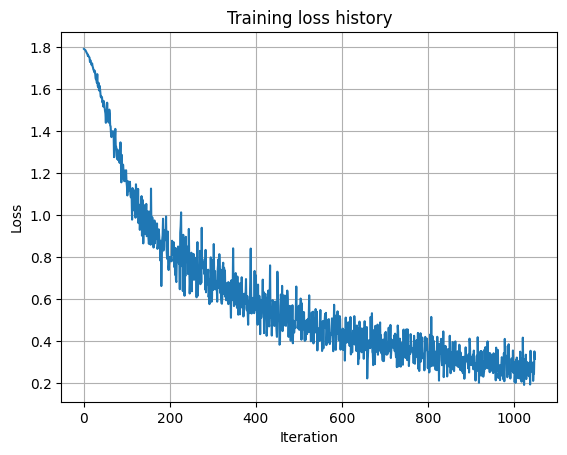

In [12]:
import matplotlib.pyplot as plt

plt.plot(loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.grid()
plt.show()